In [2]:
import numpy
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import pyLDAvis.gensim_models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
pyLDAvis.enable_notebook()

from utils import RESOURCE_PATH, RESULT_PATH, LANGUAGE, get_sentences

In [ ]:
def lda_vis(lemma_pos):
    dct = Dictionary.load(f"{RESOURCE_PATH}/{LANGUAGE}/dictionaries/dct_top5000.dat")
    lda_model = LdaModel.load(f"{RESOURCE_PATH}/{LANGUAGE}/models/lda/{lemma_pos}.dat")

    sentences = get_sentences(lemma_pos)
    corpus = [dct.doc2bow(doc) for doc in sentences]

    lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dct)
    return pyLDAvis.display(lda_display)

In [ ]:
html = lda_vis("atmosfera_NOUN")
print(dir(html))
with open("test.html", "w", encoding="utf-8") as out:
    out.write(html.__html__())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__html__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_data', '_data_and_metadata', '_read_flags', '_repr_html_', '_show_mem_addr', 'data', 'filename', 'metadata', 'reload', 'url']


Text(0.5, 0, 'Topic ID')

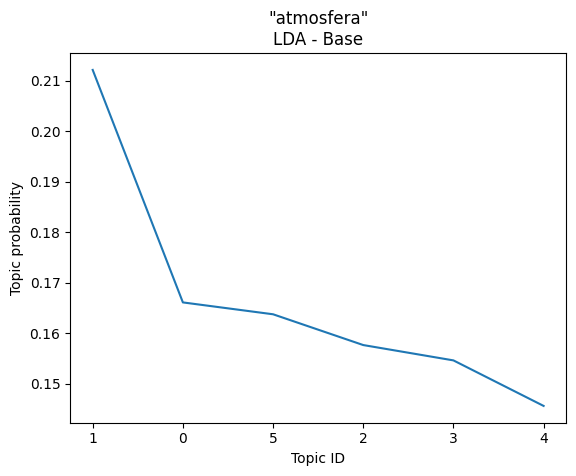

In [ ]:
td = '{"1": 0.2121138658579462, "0": 0.16612293690295074, "5": 0.16377588616404182, "2": 0.15768720555204102, "3": 0.15465370398342818, "4": 0.14564640153959205}'
import json
td = json.loads(td)
plt.plot(td.keys(), td.values())
plt.title("\"atmosfera\"\nLDA - Base")
plt.ylabel("Topic probability")
plt.xlabel("Topic ID")

In [ ]:
def build_correlation(model_type: str, mode: str, ontology: str, dct: Dictionary, show: bool = True):
    path_dict = f"{RESOURCE_PATH}/{LANGUAGE}/dictionaries/dct_onto.tsv"
    path_topic_distribution = f"{RESULT_PATH}/{LANGUAGE}/{model_type}/td_{mode}.txt"

    lemmas = set(dct.values())

    # Get number of topics for each lemma
    lemma_topic = {}
    with open(path_topic_distribution, "r", encoding="utf-8") as infile:
        for line in infile:
            line = line.strip()
            lemma_pos, n_topic, _ = line.split("\t")

            if lemma_pos in lemmas:
                lemma_topic[lemma_pos] = float(n_topic)

    # Get number of senses for each lemma
    lemma_senses = {}
    with open(path_dict, "r", encoding="utf-8") as infile:
        for line in infile:
            lemma_pos, senses_wnet, senses_wikt = line.strip().split("\t")
            senses_wnet = int(senses_wnet)
            senses_wikt = int(senses_wikt)
            
            if lemma_pos in lemmas:
                lemma_senses[lemma_pos] = senses_wnet, senses_wikt

    result = {}

    # Construct the arrays for use in spearmanr
    tot_topics = []
    tot_senses_wnet = []
    tot_senses_wikt = []
    
    # Build correlation for each POS
    for pos in ["ADJ", "ADV", "NOUN", "VER"]:
        topics = []
        senses_wnet = []
        senses_wikt = []
        
        for lemma_pos, (s_wnet, s_wikt) in lemma_senses.items():
            if lemma_pos.endswith(pos) and lemma_pos in lemma_topic:
                n_topic = lemma_topic[lemma_pos]

                topics.append(n_topic)
                senses_wnet.append(s_wnet)
                senses_wikt.append(s_wikt)

                if lemma_pos in lemmas:
                    lemma_senses[lemma_pos] = senses_wnet, senses_wikt

        if show == True:
            if ontology == "wnet":
                n_senses = senses_wnet
            elif ontology == "wikt":
                n_senses = senses_wikt

        plt.plot(n_senses, topics, ".")
        xticks(range(1, int(max(n_senses)) + 1))
        plt.title(f"{model_type} - {ontology} - {mode} - {pos}")
        plt.xlabel("n_senses")
        plt.ylabel("n_topics")
        plt.show()

        coeff_wnet = spearmanr(senses_wnet, topics)
        coeff_wikt = spearmanr(senses_wikt, topics)
        print(coeff_wikt)

        tot_topics.extend(topics)
        tot_senses_wnet.extend(senses_wnet)
        tot_senses_wikt.extend(senses_wikt)

        result[pos] = (coeff_wnet, coeff_wikt)

    if show == True:
        if ontology == "wnet":
            n_senses_tot = tot_senses_wnet
        elif ontology == "wikt":
            n_senses_tot = tot_senses_wikt

        plt.plot(n_senses_tot, tot_topics, ".")
        xticks(range(int(max(n_senses_tot)) + 1))
        plt.title(f"{model_type} - {ontology} - {mode} - TOT")
        plt.xlabel("Number of senses")
        plt.ylabel("Number of topics")
        plt.show()

    # Build total correlation
    coeff_wnet_tot = spearmanr(tot_senses_wnet, tot_topics)
    coeff_wikt_tot = spearmanr(tot_senses_wikt, tot_topics)

    result["TOT"] = (coeff_wnet_tot, coeff_wikt_tot)

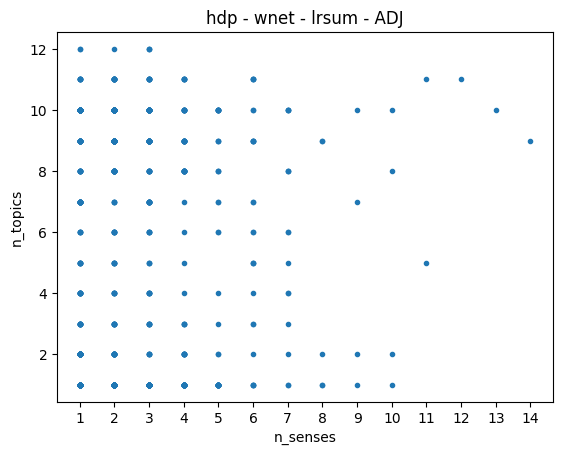

SignificanceResult(statistic=0.08106983298707204, pvalue=0.014221453649264885)


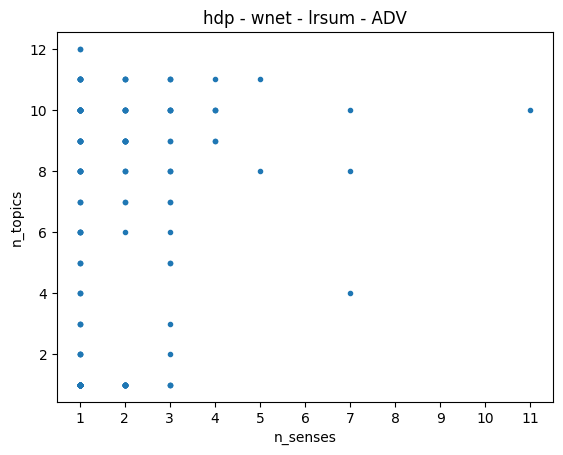

SignificanceResult(statistic=-0.05814881700195705, pvalue=0.4513226899791286)


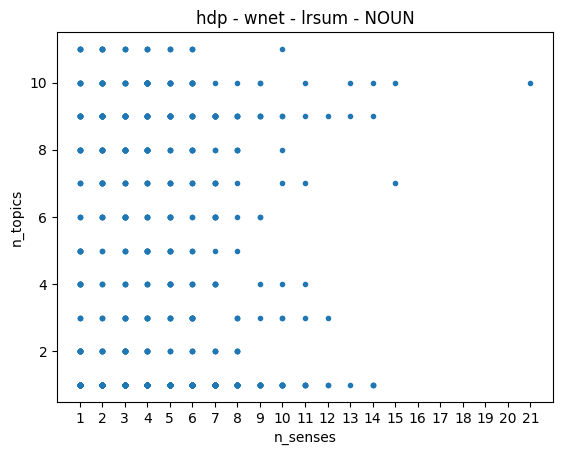

SignificanceResult(statistic=-0.03734572505820559, pvalue=0.23921579201645402)


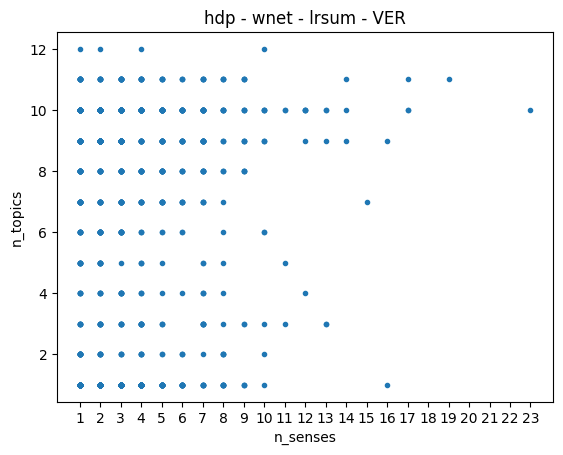

SignificanceResult(statistic=0.06730724459235608, pvalue=0.03367664545532052)


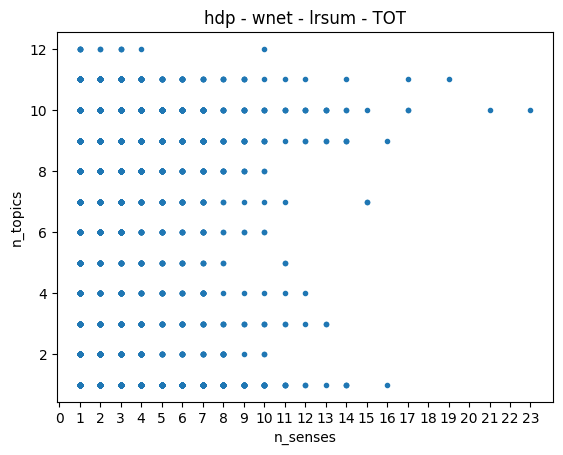

In [ ]:
dct = dct = Dictionary.load(f"{RESOURCE_PATH}/{LANGUAGE}/dictionaries/dct_top5000_sample5000.dat")
build_correlation("hdp", "lrsum", "wnet", dct)

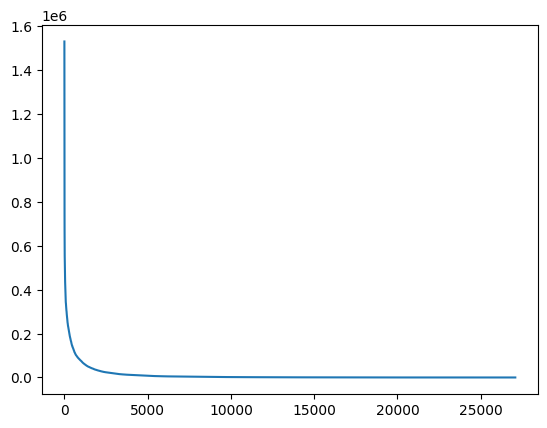

In [24]:
plt.plot(sorted(list(dct.dfs.values()), reverse=True))

In [43]:
dct = Dictionary.load(f"{RESOURCE_PATH}/{LANGUAGE}/dictionaries/dct_onto.dat")
df = dict(sorted(dct.dfs.items(), key=lambda x: x[1], reverse=True))

In [44]:
df = dict((dct[k], v/dct.num_docs) for k, v in df.items())

In [46]:
df

{'potere_VER': 0.07705835136091838,
 'articolo_NOUN': 0.061942877873869505,
 'numero_NOUN': 0.0603482820148331,
 'dovere_VER': 0.05525296809916912,
 'lavoro_NOUN': 0.05127564395329442,
 'dare_VER': 0.04544114743218146,
 'legge_NOUN': 0.04506757769739331,
 'servizio_NOUN': 0.04406068186598939,
 'pubblico_ADJ': 0.03943708912931712,
 'volere_VER': 0.03763435580548166,
 'attività_NOUN': 0.037079389712550224,
 'italiano_ADJ': 0.03390611172273209,
 'diverso_ADJ': 0.031172475655898663,
 'sistema_NOUN': 0.03079517928854455,
 'nazionale_ADJ': 0.02920612301845756,
 'punto_NOUN': 0.02902502881971151,
 'diritto_NOUN': 0.02875570407697128,
 'presidente_NOUN': 0.028631919443901817,
 'trovare_VER': 0.02862673237424919,
 'progetto_NOUN': 0.027884276375330114,
 'presente_ADJ': 0.0275596564628949,
 'sociale_ADJ': 0.027514634712706088,
 'vedere_VER': 0.026510256876279174,
 'corso_NOUN': 0.026147967758987995,
 'presentare_VER': 0.02605661490122233,
 'base_NOUN': 0.025878743736046844,
 'comma_NOUN': 0.0257

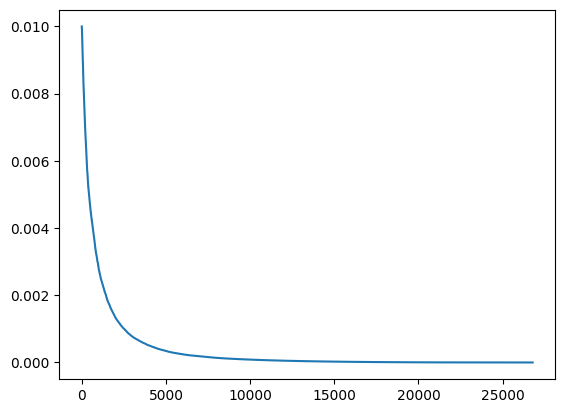

In [54]:
plt.plot(list(v for v in df.values() if v < 0.01))